## Classifying Audio Vs Visual labels 

In [2]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../PCA/Emmanuil-|PCA.ipynb
import mne 
import sys
from mne import io, EvokedArray
from mne.decoding import Vectorizer, get_coef
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from mne.decoding import UnsupervisedSpatialFilter, SlidingEstimator,cross_val_multiscore
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout
from mne.decoding import LinearModel
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = (15, 15)
matplotlib.rcParams.update({'font.size': 15})
%matplotlib inline
import time

from mne.datasets import sample
byteToGB = 1000000000

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.
ERROR:root:File `'../StimCodes.ipynb.py'` not found.
ERROR:root:File `'../PCA/Emmanuil-|PCA.ipynb.py'` not found.


In [6]:
# path = 'E:/correct_time_epochs/'
path = '/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/'
epoch_files = os.listdir(path)
epoch_files[:5]
file = os.path.join(path, epoch_files[1]) #19
file_1 = os.path.join(path,epoch_files[3])
file_2 = os.path.join(path,epoch_files[5])
file_3 = os.path.join(path, epoch_files[6])
file_4 = os.path.join(path, epoch_files[8])

In [8]:
epoch_files

['.ipynb_checkpoints',
 'large_epoch_1_epo.fif',
 'large_epoch_1_epo-1.fif',
 'large_epoch_2_epo.fif',
 'large_epoch_2_epo-1.fif',
 'large_epoch_3_epo.fif',
 'large_epoch_4_epo.fif',
 'large_epoch_4_epo-1.fif',
 'large_epoch_5_epo.fif']

In [9]:
# read epoch object 
epoch = mne.read_epochs(file, preload= True)

Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
Reading /sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/large_epoch_1_epo-1.fif ...
    Found the data of interest:
        t =       0.00 ...     500.00 ms
        0 CTF compensation matrices available
8103 matching events found
Applying baseline correction (mode: mean)
16206 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [ ]:
large_epoch = mne.epochs.concatenate_epochs([
                              mne.read_epochs(file,preload = False),
                              mne.read_epochs(file_1,preload= False),
                              mne.read_epochs(file_2,preload = False),
                              mne.read_epochs(file_3,preload = False)
#                               mne.read_epochs(file_4,preload = False)
])

In [ ]:
large_epoch

In [ ]:
large_epoch.get_data().shape

In [ ]:
epochs_list = []
total_bytes = 0
master_epochs_list = []
for file in epoch_files:
    if total_bytes/byteToGB > 4:
        master_epochs_list.append(epochs_list)
        epochs_list = []
        total_bytes = 0
    else:
        epoch_path = os.path.join(path, file)
        epoch = mne.read_epochs(epoch_path, preload = True)
        new_epoch = convert_epoch_object_events(epoch_object=epoch.copy())
        epochs_list.append(new_epoch)
        total_bytes += sys.getsizeof(new_epoch.get_data())
        print("total_bytes:", total_bytes)
#         print(new_epoch.events)
# master_epochs = mne.epochs.concatenate_epochs(epochs_list)

In [ ]:
combined_master_list_epochs = []
for i in range(len(master_epochs_list)):
    combined_master_list_epochs.append(mne.epochs.concatenate_epochs(master_epochs_list[i]))
 

In [ ]:
#save epochs
count = 1
os.chdir('/sharedData3/proj_mdg/scratch-eproj/LARGE_EPOCH_OBJECTS/')
for epoch in combined_master_list_epochs:
    epoch.save('large_epoch_{0}_epo.fif'.format(count))
    count+=1

In [21]:
# drop bad channels 
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

In [10]:
def get_audio_visual_labels(epoch_object):
    events = epoch_object.events[:,-1]
    labels = []
    for event in events:
        if event < 700:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

In [11]:
def get_frequency_band(band, epoch_object):
    """
    Description:
        returns an epoch object with a filtered frequency band
    
    Variables: 
        band : 
            'Theta':(4,7),
            'Alpha':(8,12),
            'Beta':(13,25),
            'Gamma':(30,45)
        epoch_object: mne.epoch
    -----
    returns: epoch object
    
    """
    iter_freqs = {
        'Theta':(4,7),
        'Alpha':(8,12),
        'Beta':(13,25),
        'Gamma':(30,45)
    }
    copy_epoch = epoch_object.copy()
    copy_epoch.filter(l_freq= iter_freqs[band][0],
                    h_freq = iter_freqs[band][1])
    
    return copy_epoch

In [12]:
def classify_lgr(epoch_object, data_range, do_mean_stats = False, freq_band ='None'):
    clf = make_pipeline(Vectorizer(),
                        StandardScaler(),
                        LinearModel(LogisticRegression(solver='lbfgs',max_iter=1000)))
    start_master = time.time()
#     new_events = convert_epoch_events_to_stim_combinations(epoch_object= epoch_object)
    
#     epoch_object.events = new_events
    labels = get_audio_visual_labels(epoch_object)
    
    start_master = time.time()
    cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)
    
    if freq_band.lower() == 'gamma':
        freq_data = get_frequency_band('Gamma', epoch_object=epoch_object)
    elif freq_band.lower() == 'alpha':
        freq_data = get_frequency_band('Alpha', epoch_object=epoch_object)
    elif freq_band.lower() == 'beta':
        freq_data = get_frequency_band('Beta', epoch_object=epoch_object)
    elif freq_band.lower() == 'theta':
        freq_data = get_frequency_band('Theta', epoch_object=epoch_object)
    elif freq_band.lower() =='none':
        freq_data = epoch_object.get_data()
    else:
        return "{0} is an invalid frequency band! \n Please select \
                Theta, Alpha, Beta, or Gamma".format(freq_band)
        
    
    if do_mean_stats:
        data = get_mean_band(freq_data)
        data = data.swapaxes(1,2)
    else:
        data = freq_data
    
    data = data[:,:,data_range[0]:data_range[1]]
    print(data.shape)
    print(labels.shape)
    preds = np.empty(len(data))
    
    for train, test in cv.split(data, labels):
        start = time.time()
        clf.fit(data[train], labels[train])
        preds[test] = clf.predict(data[test])
        try:
            print(clf.score(data[test], labels[test]))
        except:
            print("could not get score")
        end = time.time()
        print("kfold elapsed time: {0}".format(end - start))
    end = time.time()
    print("classification elapsed time: {0}".format(end - start_master))

    start = time.time()
    target_names = ['Audio', 'Visual']
    report = classification_report(labels, preds, target_names=target_names)
    print(report)
    end = time.time()
    print("reporting elapsed time: {0}".format(end - start))
    
    return report

## Example of plotting coefficients from MNE

In [13]:
def classifyScore(epoch_object, do_mean_stats = False):
    
    if 'Nasium' in epoch_object.ch_names:
        epoch_object.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);
    
#     copy_epoch = convert_epoch_object_events(epoch_object.copy())
    X = epoch_object.pick_types(meg=False, eeg=True)
    if do_mean_stats:
        X = get_mean_band(X)
        X = X.swapaxes(1,2)
    else:
        X = X.get_data();
        
#     new_events = convert_epoch_events_to_stim_combinations(epoch_object= copy_epoch)    
#     copy_epoch.events = new_events
    
    y = get_audio_visual_labels(epoch_object)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    
    # print(X.shape, y.shape)
    print("train shape: {0}\nlabels shape: {1}".format(X_train.shape, y_train.shape))
    # Define a unique pipeline to sequentially:
    clf = make_pipeline(
        Vectorizer(),                       # 1) vectorize across time and channels
        StandardScaler(),                   # 2) normalize features across trials
        LinearModel(
            LogisticRegression(solver='lbfgs',max_iter = 5000)))  # 3) fits a logistic regression

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    # Extract and plot patterns and filters
    for name in ('patterns_', 'filters_'):
        # The `inverse_transform` parameter will call this method on any estimator
        # contained in the pipeline, in reverse order.
        coef = get_coef(clf, name, inverse_transform=True)
        evoked = EvokedArray(coef, epoch_object.info, tmin=epoch_object.tmin)
        evoked.plot_topomap(title='EEG %s' % name[:-1], time_unit='s')
        
    return score, clf

In [ ]:
classifyScore(epoch_object=mne.epochs.concatenate_epochs([
                              mne.read_epochs(file,preload = False),
                              mne.read_epochs(file_1,preload= False),
#                               mne.read_epochs(file_2,preload = False),
#                               mne.read_epochs(file_3,preload = False)
#                               mne.read_epochs(file_4,preload = False)
]))

In [23]:
def roc_plot_evoked(epoch_object):
    if 'Nasium' in epoch_object.ch_names:
        epoch_object.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

    X = epoch_object.pick_types(meg=False, eeg=True)
    # new_events = convert_epoch_events_to_stim_combinations(epoch_object= copy_epoch)

    # copy_epoch.events = new_events

    y = get_audio_visual_labels(epoch_object)
    
    # You can retrieve the spatial filters and spatial patterns if you explicitly
    # use a LinearModel
    clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression(solver='lbfgs', max_iter = 500)))
    time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
    time_decod.fit(X.get_data(), y)

    coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
    evoked = mne.EvokedArray(coef, epoch_object.info, tmin=epoch_object.times[0])
    joint_kwargs = dict(ts_args=dict(time_unit='s'),
                        topomap_args=dict(time_unit='s'))
    evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                      **joint_kwargs)
    evoked.plot_joint(title='patterns',
                      **joint_kwargs)
    
    return coef

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected


<ipython-input-11-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


[........................................] 100.00% Fitting SlidingEstimator |  


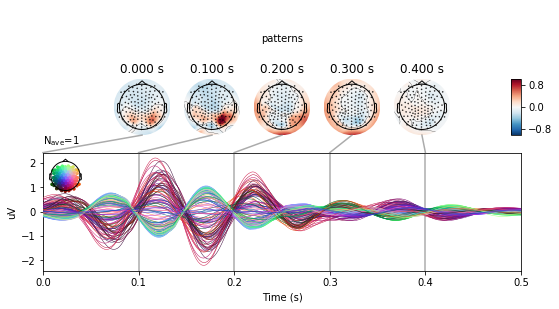

In [18]:
coef_gamma = roc_plot_evoked(get_frequency_band(epoch_object=epoch, band='Alpha'))

Setting up band-pass filter from 13 - 25 Hz
l_trans_bandwidth chosen to be 3.2 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 521 samples (1.018 sec) selected


<ipython-input-11-de3e0c320acf>:25: RuntimeWarning: filter_length (521) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


[........................................] 100.00% Fitting SlidingEstimator |  


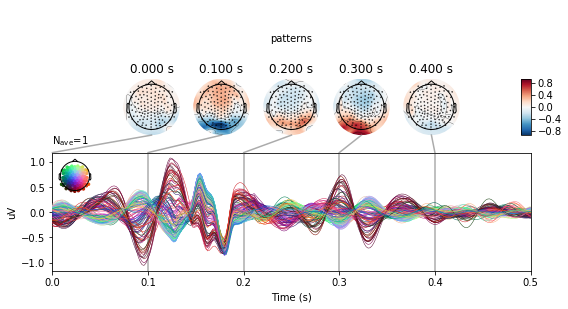

In [19]:
coef = roc_plot_evoked(get_frequency_band(epoch_object=epoch, band='Beta'))

In [22]:

evoked = mne.EvokedArray(coef, epoch.info, tmin=epoch.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(title='patterns',
                  **joint_kwargs,);

ValueError: Info (125) and data (124) must have same number of channels.

In [ ]:
# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression( max_iter = 500)))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                  **joint_kwargs)

In [ ]:
roc_plot_evoked()

In [ ]:
evoked.plot_joint(times=np.arange(0., .600, .100), title='patterns',
                  **joint_kwargs);

In [15]:
# We will train the classifier on all left visual vs auditory trials on MEG
def roc_score(epoch_object):
    
    clf = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs', max_iter = 500))
    y = get_audio_visual_labels(epoch_object)

    time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
    scores = cross_val_multiscore(time_decod, epoch_object.get_data(), y, cv=5, n_jobs=1)

    # Mean scores across cross-validation splits
    scores = np.mean(scores, axis=0)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(epoch_object.times, scores, label='score')
    ax.axhline(.5, color='k', linestyle='--', label='chance')
    ax.set_xlabel('Times')
    ax.set_ylabel('AUC')  # Area Under the Curve
    ax.legend()
    ax.axvline(.0, color='k', linestyle='-')
    ax.set_title('Sensor space decoding')

Setting up band-pass filter from 8 - 12 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 3.0 Hz
Filter length of 845 samples (1.650 sec) selected


<ipython-input-11-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


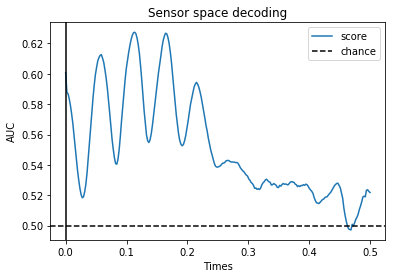

In [16]:
roc_score(get_frequency_band(epoch_object=epoch, band='Alpha'))

Setting up band-pass filter from 13 - 25 Hz
l_trans_bandwidth chosen to be 3.2 Hz
h_trans_bandwidth chosen to be 6.2 Hz
Filter length of 521 samples (1.018 sec) selected


<ipython-input-11-de3e0c320acf>:25: RuntimeWarning: filter_length (521) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


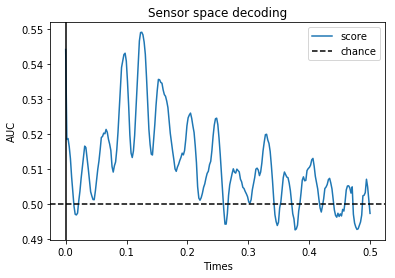

In [24]:
roc_score(get_frequency_band(epoch_object=epoch, band='Beta'))

In [ ]:
# theta band roc 
try:
    roc_score(get_frequency_band(epoch_object=epoch, band='Theta'))
except:
    print("oops, something went wrong.")

Setting up band-pass filter from 4 - 7 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 845 samples (1.650 sec) selected


<ipython-input-11-de3e0c320acf>:25: RuntimeWarning: filter_length (845) is longer than the signal (257), distortion is likely. Reduce filter length or filter a longer signal.
  h_freq = iter_freqs[band][1])


[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[..............                          ]  36.96% Fitting SlidingEstimator |  

In [ ]:
# Gamma band roc 
try:
    roc_score(get_frequency_band(epoch_object=epoch, band='Gamma'))
except:
    print("oops, something went wrong.")

In [ ]:
#coef Theta
try:
    coef_theta = roc_plot_evoked(get_frequency_band(epoch_object=epoch, band='Theta'))
except:
    print("oops, something went wrong.")

In [ ]:
#Gamma Theta
try:
    coef_theta = roc_plot_evoked(get_frequency_band(epoch_object=epoch, band='Gamma'))
except:
    print("oops, something went wrong.")

In [ ]:
roc_score(epoch.copy())

In [ ]:
data_path = sample.data_path()

In [ ]:
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
tmin, tmax = -0.200, 0.500
event_id = dict(audio_left=1, visual_left=3)
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.filter(None, 20., fir_design='firwin')
events = mne.find_events(raw, 'STI 014')

raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more
picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=True, eog=True,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(None, 0.), preload=True,
                    reject=dict(grad=4000e-13, eog=150e-6), decim=10)
epochs.pick_types(meg=True, exclude='bads')

In [ ]:

X = epochs.get_data()  # MEG signals: n_epochs, n_channels, n_times
y = epochs.events[:, 2]  # target: Audio left or right

clf = make_pipeline(StandardScaler(), LogisticRegression(solver = 'lbfgs'))

time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

# You can retrieve the spatial filters and spatial patterns if you explicitly
# use a LinearModel
clf = make_pipeline(StandardScaler(), LinearModel(LogisticRegression(solver = 'lbfgs')))
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
time_decod.fit(X, y)

coef = get_coef(time_decod, 'patterns_', inverse_transform=True)
evoked = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit='s'),
                    topomap_args=dict(time_unit='s'))
evoked.plot_joint(times=np.arange(0., .500, .100), title='patterns',
                  **joint_kwargs)

In [ ]:
epochs.info

In [ ]:
epochs.info['chs']

In [ ]:
epoch.info

In [ ]:
mask_params = dict(marker='o', markerfacecolor='w', markeredgecolor='k',
     linewidth=0, markersize=4)
mne.viz.plot_evoked_topomap(evoked = evoked,cbar_fmt='%3.1f', 
                            mask =
                            mask_params=mask_params)